# Youm7 Scraper

### 1. Setup and Configuration


In [12]:
import asyncio
import aiohttp
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from datetime import datetime
import nest_asyncio
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

# Apply nest_asyncio for Jupyter notebook
nest_asyncio.apply()

# Configure visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline


### 2. Constants and Helper Functions


In [13]:
SECTIONS = {
    "عاجل": "https://www.youm7.com/Section/%D8%A3%D8%AE%D8%A8%D8%A7%D8%B1-%D8%B9%D8%A7%D8%AC%D9%84%D8%A9/65/1",
    "فن": "https://www.youm7.com/Section/%D9%81%D9%86/48/1",
    "كرة عالمية": "https://www.youm7.com/Section/%D9%83%D8%B1%D8%A9-%D8%B9%D8%A7%D9%84%D9%85%D9%8A%D8%A9/332/1",
    "رياضة": "https://www.youm7.com/Section/%D8%A3%D8%AE%D8%A8%D8%A7%D8%B1-%D8%A7%D9%84%D8%B1%D9%8A%D8%A7%D8%B6%D8%A9/298/1",
    "تحقيقات": "https://www.youm7.com/Section/%D8%AA%D8%AD%D9%82%D9%8A%D9%82%D8%A7%D8%AA-%D9%88%D9%85%D9%84%D9%81%D8%A7%D8%AA/12/1",
    "اقتصاد": "https://www.youm7.com/Section/%D8%A7%D9%82%D8%AA%D8%B5%D8%A7%D8%AF-%D9%88%D8%A8%D9%88%D8%B1%D8%B5%D8%A9/297/1",
    "أخبار عالمية": "https://www.youm7.com/Section/%D8%A3%D8%AE%D8%A8%D8%A7%D8%B1-%D8%B9%D8%A7%D9%84%D9%85%D9%8A%D8%A9/286/1",
    "حوادث": "https://www.youm7.com/Section/%D8%AD%D9%88%D8%A7%D8%AF%D8%AB/203/1",
    "سياسة": "https://www.youm7.com/Section/%D8%B3%D9%8A%D8%A7%D8%B3%D8%A9/319/1",
    "تقارير مصرية": "https://www.youm7.com/Section/%D8%AA%D9%82%D8%A7%D8%B1%D9%8A%D8%B1-%D9%85%D8%B5%D8%B1%D9%8A%D8%A9/97/1",
    "صحة":"https://www.youm7.com/Section/%D8%B5%D8%AD%D8%A9-%D9%88%D8%B7%D8%A8/245/1",
    "تكنولوجيا": "https://www.youm7.com/Section/%D8%B9%D9%84%D9%88%D9%85-%D9%88-%D8%AA%D9%83%D9%86%D9%88%D9%84%D9%88%D8%AC%D9%8A%D8%A7/328/1",
    "مرأة ومنوعات":"https://www.youm7.com/Section/%D8%A7%D9%84%D9%85%D8%B1%D8%A3%D8%A9-%D9%88%D8%A7%D9%84%D9%85%D9%86%D9%88%D8%B9%D8%A7%D8%AA/89/1",
    "دين وحياة": "https://www.youm7.com/Section/%D8%AF%D9%8A%D9%86-%D9%88%D8%AD%D9%8A%D8%A7%D8%A9/359/1",
    "عرب":"https://www.youm7.com/Section/%D8%A3%D8%AE%D8%A8%D8%A7%D8%B1-%D8%B9%D8%B1%D8%A8%D9%8A%D8%A9/88/1"
}

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

### 3. Scraping Functions


In [14]:
async def fetch(session, url, semaphore):
    async with semaphore:
        try:
            async with session.get(url, headers=HEADERS) as response:
                return await response.text()
        except Exception as e:
            print(f"Request failed for {url}: {e}")
            return None

async def get_article_links(session, section_url, max_links=10):
    links = []
    page = 1
    while len(links) < max_links:
        current_url = f"{section_url.split('/1')[0]}/{page}"
        print(f"Scraping page {page}: {current_url}")
        html = await fetch(session, current_url, asyncio.Semaphore(5))
        if not html:
            break
            
        soup = BeautifulSoup(html, "html.parser")
        article_containers = soup.find_all("div", class_=["bigOneSec", "smallOneSec"])
        
        page_links = []
        for container in article_containers:
            link_tag = container.find("a", href=True)
            if link_tag and "/story/" in link_tag["href"]:
                full_url = urljoin(section_url, link_tag["href"])
                if full_url not in links and full_url not in page_links:
                    page_links.append(full_url)
        
        if not page_links:
            break
            
        links.extend(page_links)
        if len(links) >= max_links:
            links = links[:max_links]
            break
        page += 1
        
    return links

async def scrape_article(session, url, article_number, section_name):
    html = await fetch(session, url, asyncio.Semaphore(5))
    if not html:
        return None
        
    try:
        soup = BeautifulSoup(html, "html.parser")
        
        # Extract article data
        title = soup.find("h1").text.strip() if soup.find("h1") else "No title"
        article_body = soup.find("div", {"id": "articleBody"}) or soup.find("div", class_="articleCont")
        paragraphs = article_body.find_all("p") if article_body else []
        text = "\n".join([p.text.strip() for p in paragraphs if p.text.strip()])
        
        # Extract metadata
        date_element = soup.find("span", class_="newsStoryDate")
        date = date_element.text.strip() if date_element else "No date"
        
        writer_element = soup.find("span", class_="writeBy")
        writer = re.sub(r'^كتب\s+', '', writer_element.text.strip()) if writer_element else "No writer"
        
        # Extract images
        images = []
        main_image = soup.find("div", class_="img-cont")
        if main_image and main_image.find("img"):
            img_element = main_image.find("img")
            img_url = img_element.get("src") or img_element.get("data-src")
            img_caption = main_image.find("span", class_="img-cap").text.strip() if main_image.find("span", class_="img-cap") else ""
            if img_url:
                images.append({"url": img_url, "caption": img_caption})
        
        if article_body:
            for img in article_body.find_all("img"):
                img_url = img.get("src") or img.get("data-src")
                if img_url and not any(img_url == existing_img["url"] for existing_img in images):
                    img_caption = img.find_next("span", class_="img-cap").text.strip() if img.find_next("span", class_="img-cap") else ""
                    images.append({"url": img_url, "caption": img_caption})
        
        return {
            "id": article_number,
            "section": section_name,
            "title": title,
            "text": text,
            "url": url,
            "date": date,
            "writer": writer,
            "images": images,
            "word_count": len(text.split()),
            "image_count": len(images),
            "scrape_time": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        
    except Exception as e:
        print(f"Failed to scrape {url}: {e}")
        return None

### 4. Main Scraping Process


In [15]:
async def scrape_all_sections(max_articles_per_section=5):
    all_articles = []
    article_id = 1
    async with aiohttp.ClientSession() as session:
        tasks = []
        for section_name, section_url in SECTIONS.items():
            print(f"\n{'='*50}")
            print(f"Scraping section: {section_name}")
            print(f"{'='*50}")
            
            # Get article links for this section
            article_links = await get_article_links(session, section_url, max_articles_per_section)
            print(f"Found {len(article_links)} articles in '{section_name}' section")
            
            # Create scraping tasks for each article
            for link in article_links:
                tasks.append(scrape_article(session, link, article_id, section_name))
                article_id += 1
        
        # Execute all scraping tasks
        results = await asyncio.gather(*tasks)
        all_articles.extend([article for article in results if article is not None])
    
    return all_articles

# Run the scraper
articles_data = await scrape_all_sections(max_articles_per_section=500)

# Save to JSON
with open("youm7_articles.json", "w", encoding="utf-8") as f:
    json.dump(articles_data, f, ensure_ascii=False, indent=2)

print(f"\nScraping complete! Saved {len(articles_data)} articles to youm7_articles.json")


Scraping section: عاجل
Scraping page 1: https://www.youm7.com/Section/%D8%A3%D8%AE%D8%A8%D8%A7%D8%B1-%D8%B9%D8%A7%D8%AC%D9%84%D8%A9/65/1
Scraping page 2: https://www.youm7.com/Section/%D8%A3%D8%AE%D8%A8%D8%A7%D8%B1-%D8%B9%D8%A7%D8%AC%D9%84%D8%A9/65/2
Scraping page 3: https://www.youm7.com/Section/%D8%A3%D8%AE%D8%A8%D8%A7%D8%B1-%D8%B9%D8%A7%D8%AC%D9%84%D8%A9/65/3
Scraping page 4: https://www.youm7.com/Section/%D8%A3%D8%AE%D8%A8%D8%A7%D8%B1-%D8%B9%D8%A7%D8%AC%D9%84%D8%A9/65/4
Scraping page 5: https://www.youm7.com/Section/%D8%A3%D8%AE%D8%A8%D8%A7%D8%B1-%D8%B9%D8%A7%D8%AC%D9%84%D8%A9/65/5
Scraping page 6: https://www.youm7.com/Section/%D8%A3%D8%AE%D8%A8%D8%A7%D8%B1-%D8%B9%D8%A7%D8%AC%D9%84%D8%A9/65/6
Scraping page 7: https://www.youm7.com/Section/%D8%A3%D8%AE%D8%A8%D8%A7%D8%B1-%D8%B9%D8%A7%D8%AC%D9%84%D8%A9/65/7
Scraping page 8: https://www.youm7.com/Section/%D8%A3%D8%AE%D8%A8%D8%A7%D8%B1-%D8%B9%D8%A7%D8%AC%D9%84%D8%A9/65/8
Scraping page 9: https://www.youm7.com/Section/%D8%A3%D8%AE%D8%A

### 5. Data Analysis and Visualization


In [16]:
df = pd.DataFrame(articles_data)
# Display sample data
print("\nSample of scraped data:")
display(df.head(3))


Sample of scraped data:


,id,section,title,text,url,date,writer,images,word_count,image_count,scrape_time
0,1,عاجل,رابط مباشر.. الاستعلام عن أرقام جلوس الثانوية ...,يعلن قطاع المعاهد الأزهرية اليوم الخميس عن أرق...,https://www.youm7.com/story/2025/5/22/رابط-مبا...,الخميس، 22 مايو 2025 12:30 ص,لؤى على,[{'url': 'https://img.youm7.com/large/20210930...,126,1,2025-05-22 00:45:51
1,2,عاجل,أخبار × 24 ساعة.. رئيس الوزراء: صندوق النقد ال...,سلسلة من الأخبار التى تهم الجمهور وتتضمن عرضًا...,https://www.youm7.com/story/2025/5/22/أخبار-×-...,الخميس، 22 مايو 2025 12:00 ص,,[{'url': 'https://img.youm7.com/large/20250518...,153,1,2025-05-22 00:45:52
2,3,عاجل,شبورة ورياح وأتربة.. حالة الطقس اليوم الخميس 2...,تتوقع الهيئة العامة للأرصاد الجوية، أن يشهد ال...,https://www.youm7.com/story/2025/5/22/شبورة-ور...,الخميس، 22 مايو 2025 12:00 ص,– محمود راغب,[{'url': 'https://img.youm7.com/large/20250313...,525,1,2025-05-22 00:45:52


In [17]:
def reshape_arabic(text):
    return get_display(arabic_reshaper.reshape(text)) if isinstance(text, str) else text

df_plot = df.copy()
df_plot["section"] = df_plot["section"].apply(reshape_arabic)
df_plot["title"] = df_plot["writer"].apply(reshape_arabic)
df_plot["text"] = df_plot["section"].apply(reshape_arabic)
df_plot["writer"] = df_plot["writer"].apply(reshape_arabic)

#### 5.1 Articles Distribution by Section


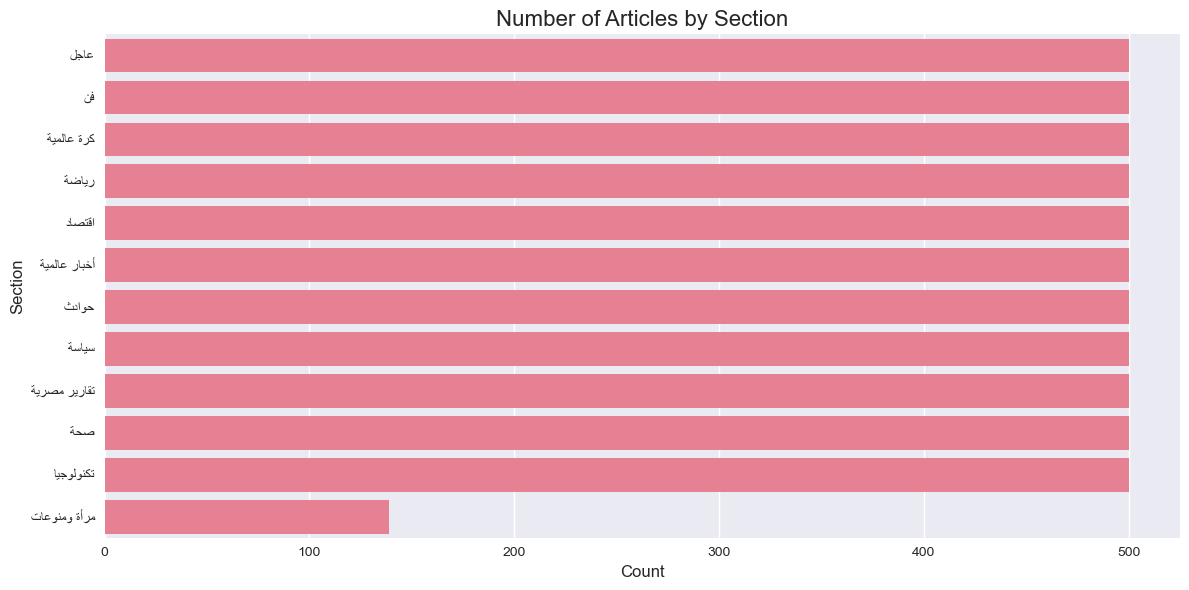

In [18]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_plot, y="section", order=df_plot["section"].value_counts().index)
plt.title("Number of Articles by Section", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Section", fontsize=12)
plt.tight_layout()
plt.show()


#### 5.2 Word Count Analysis


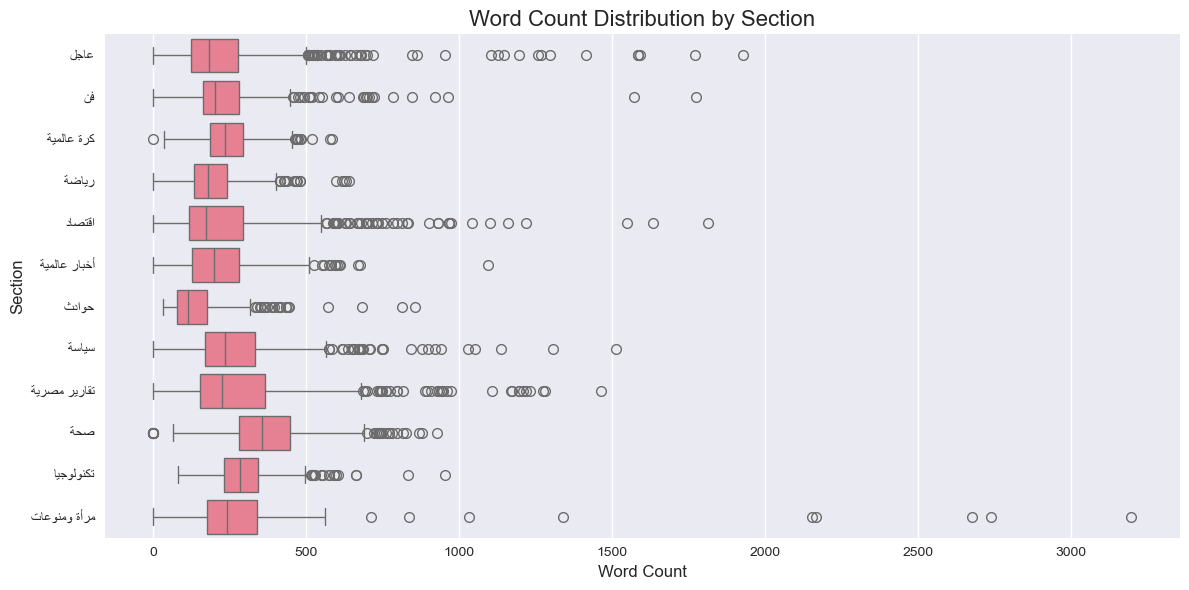

In [19]:

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_plot, x="word_count", y="section")
plt.title("Word Count Distribution by Section", fontsize=16)
plt.xlabel("Word Count", fontsize=12)
plt.ylabel("Section", fontsize=12)
plt.tight_layout()
plt.show()

#### 5.3 Most Prolific Writers


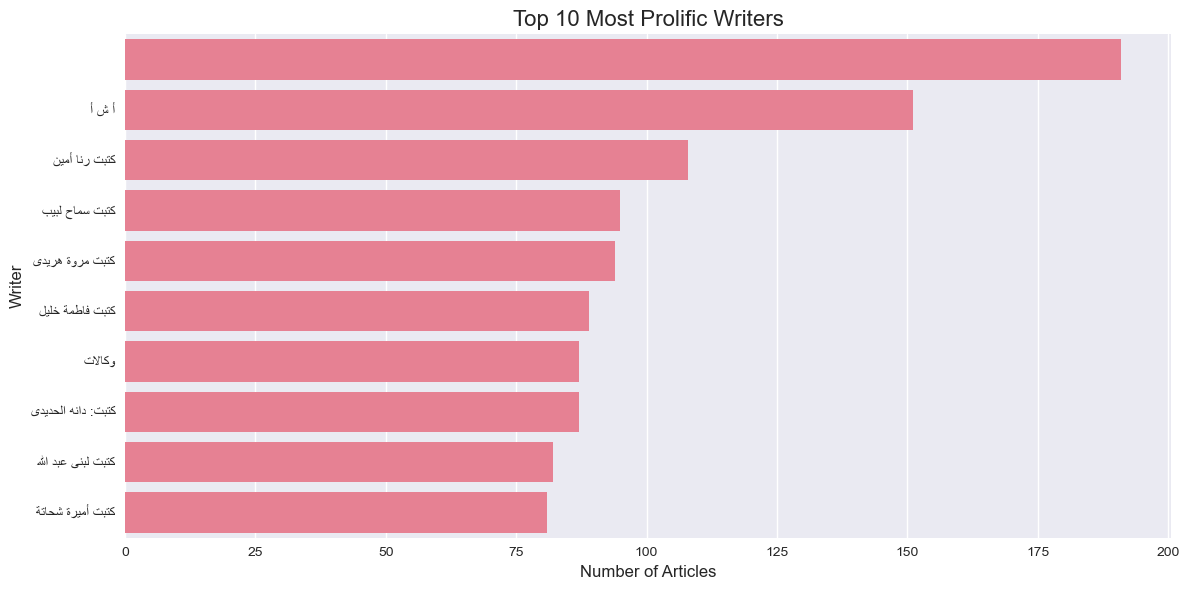

In [20]:
# Top writers analysis
top_writers = df_plot["writer"].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_writers.values, y=top_writers.index)
plt.title("Top 10 Most Prolific Writers", fontsize=16)
plt.xlabel("Number of Articles", fontsize=12)
plt.ylabel("Writer", fontsize=12)
plt.tight_layout()
plt.show()

### 6. Generate Report


In [21]:
# Generate a text report
report = f"""
YOUm7 NEWS ANALYSIS REPORT
=========================

Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
Total Articles Scraped: {len(df)}

Section Breakdown:
-----------------
{df["section"].value_counts().to_string()}

Key Statistics:
--------------
- Average word count per article: {df["word_count"].mean():.1f}
- Article with most words: "{df.loc[df["word_count"].idxmax()]["title"]}" ({df["word_count"].max()} words)
- Total images scraped: {df["image_count"].sum()}
- Most active writer: {df["writer"].value_counts().index[0]} ({df["writer"].value_counts().iloc[0]} articles)

Top Sections by Word Count:
--------------------------
{df.groupby("section")["word_count"].mean().sort_values(ascending=False).head(5).to_string()}
"""

print(report)

# Save report to file
with open("youm7_analysis_report.txt", "w", encoding="utf-8") as f:
    f.write(report)

print("Report saved to youm7_analysis_report.txt")


YOUm7 NEWS ANALYSIS REPORT

Generated on: 2025-05-22 00:51:43
Total Articles Scraped: 5639

Section Breakdown:
-----------------
section
عاجل            500
فن              500
كرة عالمية      500
رياضة           500
اقتصاد          500
أخبار عالمية    500
حوادث           500
سياسة           500
تقارير مصرية    500
صحة             500
تكنولوجيا       500
مرأة ومنوعات    139

Key Statistics:
--------------
- Average word count per article: 256.0
- Article with most words: "حظك اليوم وتوقعات الأبراج الإثنين 19 مايو على الصعيد المهنى والعاطفى والصحى" (3197 words)
- Total images scraped: 8662
- Most active writer:  (191 articles)

Top Sections by Word Count:
--------------------------
section
صحة             371.524000
مرأة ومنوعات    336.676259
تقارير مصرية    299.832000
تكنولوجيا       297.244000
سياسة           274.622000

Report saved to youm7_analysis_report.txt


### 7. Add noise (To be used in NLP Project)